# Lab: Chicago taxifare tip prediction with AutoML Tables on Vertex Pipelines using Kubeflow Pipelines SDK

## Learning objectives

1. Perform exploratory data analysis (EDA) on tabular data using BigQuery.
2. Create a BigQuery dataset for a ML classification task.
3. Define an AutoML tables pipeline using the Kubeflow Pipelines (KFP) SDK for model training, evaluation, and conditional deployment.
4. Create a custom model evaluation component using the KFP SDK.
5. Incorporate pre-built KFP components into your pipeline from `google_cloud_components`.
6. Query your model for online predictions and explanations.

## Setup

### Define constants

In [3]:
# Add installed depedencies to Python PATH variable.
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


In [4]:
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
REGION = 'us-central1'

BQ_DATASET_NAME = 'chicago_taxi'
BQ_TABLE_NAME = 'chicago_taxi_tips_raw'
BQ_LOCATION = 'US'

!echo {PROJECT_ID}
!echo {REGION}

dougkelly-vertex-demos
us-central1


### Create Cloud Storage bucket for storing Vertex Pipeline artifacts

In [5]:
BUCKET_NAME = f"gs://{PROJECT_ID}-bucket"
print(BUCKET_NAME)

gs://dougkelly-vertex-demos-bucket


In [4]:
!gsutil ls -al $BUCKET_NAME

                                 gs://dougkelly-vertex-demos-bucket/pipeline_root/


In [5]:
USER = "dougkelly"  # <---CHANGE THIS
PIPELINE_ROOT = "{}/pipeline_root/{}".format(BUCKET_NAME, USER)

PIPELINE_ROOT

'gs://dougkelly-vertex-demos-bucket/pipeline_root/dougkelly'

### Create BigQuery dataset

In [6]:
!bq --location=US mk -d \
$PROJECT_ID:$BQ_DATASET_NAME

BigQuery error in mk operation: Dataset 'dougkelly-vertex-demos:chicago_taxi'
already exists.


## Exploratory Data Analysis in BigQuery

In [7]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek
;

Downloading: 100%|██████████| 7/7 [00:01<00:00,  6.01rows/s]


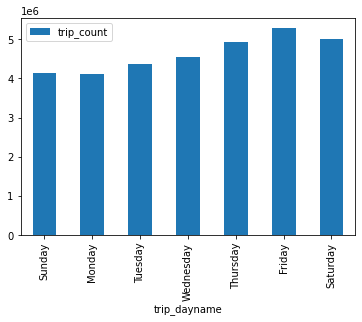

In [8]:
data.plot(kind='bar', x='trip_dayname', y='trip_count');

### Create BigQuery dataset for ML classification task

In [9]:
SAMPLE_SIZE = 100000
YEAR = 2020

In [39]:
sql_script = '''
CREATE OR REPLACE TABLE `@PROJECT_ID.@DATASET.@TABLE` 
AS (
    WITH
      taxitrips AS (
      SELECT
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      CONCAT(
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickup_longitude,
              pickup_latitude), 0.1)), 
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropoff_longitude,
              dropoff_latitude), 0.1))
      ) AS loc_cross,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      IF(ABS(MOD(FARM_FINGERPRINT(STRING(trip_start_timestamp)), 10)) < 9, 'UNASSIGNED', 'TEST') AS data_split
    FROM
      taxitrips
    LIMIT @LIMIT
)
'''

In [40]:
sql_script = sql_script.replace(
    '@PROJECT_ID', PROJECT_ID).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(YEAR)).replace(
    '@LIMIT', str(SAMPLE_SIZE))

In [41]:
# print(sql_script)

In [12]:
from google.cloud import bigquery

In [43]:
bq_client = bigquery.Client(project=PROJECT_ID, location=BQ_LOCATION)
job = bq_client.query(sql_script)
_ = job.result()

#### Verify data split proportions

In [44]:
%%bigquery

SELECT data_split, COUNT(*)
FROM dougkelly-vertex-demos.chicago_taxi.chicago_taxi_tips_raw
GROUP BY data_split

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.55rows/s]


,data_split,f0_
0,UNASSIGNED,90081
1,TEST,9919


### Create 

### Import libraries

In [45]:
import json
import logging
from typing import NamedTuple

import kfp
# from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip
from kfp.v2 import dsl
from kfp.v2.dsl import (ClassificationMetrics, Input, Metrics, Model, Output,
                        component)
from kfp.v2.google.client import AIPlatformClient

## Create and run an AutoML Tabular classification pipeline using Kubeflow Pipelines SDK

### Create a custom KFP evaluation component

In [46]:
@component(
    base_image="gcr.io/deeplearning-platform-release/tf2-cpu.2-3:latest",
    output_component_file="components/tables_eval_component.yaml", # Optional: you can use this to load the component later
    packages_to_install=["google-cloud-aiplatform==1.0.0"],
)
def classif_model_eval_metrics(
    project: str,
    location: str,
    api_endpoint: str,
    thresholds_dict_str: str,
    model: Input[Model],
    metrics: Output[Metrics],
    metricsc: Output[ClassificationMetrics],
) -> NamedTuple("Outputs", [("dep_decision", str)]):  # Return parameter.

    """This function renders evaluation metrics for an AutoML Tabular classification model.
    It retrieves the classification model evaluation generated by the AutoML Tabular training
    process, does some parsing, and uses that info to render the ROC curve and confusion matrix
    for the model. It also uses given metrics threshold information and compares that to the
    evaluation results to determine whether the model is sufficiently accurate to deploy.
    """
    import json
    import logging

    from google.cloud import aiplatform

    # Fetch model eval info
    def get_eval_info(client, model_name):
        from google.protobuf.json_format import MessageToDict

        response = client.list_model_evaluations(parent=model_name)
        metrics_list = []
        metrics_string_list = []
        for evaluation in response:
            print("model_evaluation")
            print(" name:", evaluation.name)
            print(" metrics_schema_uri:", evaluation.metrics_schema_uri)
            metrics = MessageToDict(evaluation._pb.metrics)
            for metric in metrics.keys():
                logging.info("metric: %s, value: %s", metric, metrics[metric])
            metrics_str = json.dumps(metrics)
            metrics_list.append(metrics)
            metrics_string_list.append(metrics_str)

        return (
            evaluation.name,
            metrics_list,
            metrics_string_list,
        )

    # Use the given metrics threshold(s) to determine whether the model is 
    # accurate enough to deploy.
    def classification_thresholds_check(metrics_dict, thresholds_dict):
        for k, v in thresholds_dict.items():
            logging.info("k {}, v {}".format(k, v))
            if k in ["auRoc", "auPrc"]:  # higher is better
                if metrics_dict[k] < v:  # if under threshold, don't deploy
                    logging.info(
                        "{} < {}; returning False".format(metrics_dict[k], v)
                    )
                    return False
        logging.info("threshold checks passed.")
        return True

    def log_metrics(metrics_list, metricsc):
        test_confusion_matrix = metrics_list[0]["confusionMatrix"]
        logging.info("rows: %s", test_confusion_matrix["rows"])

        # log the ROC curve
        fpr = []
        tpr = []
        thresholds = []
        for item in metrics_list[0]["confidenceMetrics"]:
            fpr.append(item.get("falsePositiveRate", 0.0))
            tpr.append(item.get("recall", 0.0))
            thresholds.append(item.get("confidenceThreshold", 0.0))
        print(f"fpr: {fpr}")
        print(f"tpr: {tpr}")
        print(f"thresholds: {thresholds}")
        metricsc.log_roc_curve(fpr, tpr, thresholds)

        # log the confusion matrix
        annotations = []
        for item in test_confusion_matrix["annotationSpecs"]:
            annotations.append(item["displayName"])
        logging.info("confusion matrix annotations: %s", annotations)
        metricsc.log_confusion_matrix(
            annotations,
            test_confusion_matrix["rows"],
        )

        # log textual metrics info as well
        for metric in metrics_list[0].keys():
            if metric != "confidenceMetrics":
                val_string = json.dumps(metrics_list[0][metric])
                metrics.log_metric(metric, val_string)
        # metrics.metadata["model_type"] = "AutoML Tabular classification"

    logging.getLogger().setLevel(logging.INFO)
    aiplatform.init(project=project)
    # extract the model resource name from the input Model Artifact
    model_resource_path = model.uri.replace("aiplatform://v1/", "")
    logging.info("model path: %s", model_resource_path)

    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    client = aiplatform.gapic.ModelServiceClient(client_options=client_options)
    eval_name, metrics_list, metrics_str_list = get_eval_info(
        client, model_resource_path
    )
    logging.info("got evaluation name: %s", eval_name)
    logging.info("got metrics list: %s", metrics_list)
    log_metrics(metrics_list, metricsc)

    thresholds_dict = json.loads(thresholds_dict_str)
    deploy = classification_thresholds_check(metrics_list[0], thresholds_dict)
    if deploy:
        dep_decision = "true"
    else:
        dep_decision = "false"
    logging.info("deployment decision is %s", dep_decision)

    return (dep_decision,)

In [47]:
import time

DISPLAY_NAME = "automl-tab-chicago-taxi-tips-{}".format(str(int(time.time())))
print(DISPLAY_NAME)

automl-tab-chicago-taxi-tips-1624573137


### Define the pipeline

In [48]:
@kfp.dsl.pipeline(name="automl-tab-chicago-taxi-tips-train", pipeline_root=PIPELINE_ROOT)
def pipeline(
    bq_source: str = "bq://dougkelly-vertex-demos:chicago_taxi.chicago_taxi_tips_raw",
    display_name: str = DISPLAY_NAME,
    project: str = PROJECT_ID,
    gcp_region: str = REGION,
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
    thresholds_dict_str: str = '{"auRoc": 0.90}',
):
    dataset_create_op = gcc_aip.TabularDatasetCreateOp(
        project=project, display_name=display_name, bq_source=bq_source
    )

    training_op = gcc_aip.AutoMLTabularTrainingJobRunOp(
        project=project,
        display_name=display_name,
        optimization_prediction_type="classification",
        optimization_objective="maximize-au-roc", # binary classification        
        budget_milli_node_hours=750,
        training_fraction_split=0.9,
        validation_fraction_split=0.1,
        column_transformations=[
            {"numeric": {"column_name": "trip_seconds"}},            
            {"numeric": {"column_name": "trip_miles"}},            
            {"categorical": {"column_name": "trip_month"}},
            {"categorical": {"column_name": "trip_day"}},
            {"categorical": {"column_name": "trip_day_of_week"}},            
            {"categorical": {"column_name": "trip_hour"}},            
            {"categorical": {"column_name": "payment_type"}},
            {"numeric": {"column_name": "euclidean"}},
            {"categorical": {"column_name": "tip_bin"}},
        ],
        dataset=dataset_create_op.outputs["dataset"],
        target_column="tip_bin",
    )
    
    model_eval_task = classif_model_eval_metrics(
        project,
        gcp_region,
        api_endpoint,
        thresholds_dict_str,
        training_op.outputs["model"],
    )

    with dsl.Condition(
        model_eval_task.outputs["dep_decision"] == "true",
        name="deploy_decision",
    ):

        deploy_op = gcc_aip.ModelDeployOp(  # noqa: F841
            model=training_op.outputs["model"],
            project=project,
            machine_type="n1-standard-4",
        )

### Compile and run the pipeline

In [49]:
from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="automl-tab-chicago-taxi-tips-train_pipeline.json"
)

### Run the pipeline

In [50]:
from kfp.v2.google.client import AIPlatformClient  # noqa: F811

api_client = AIPlatformClient(project_id=PROJECT_ID, region=REGION)

In [51]:
response = api_client.create_run_from_job_spec(
    "automl-tab-chicago-taxi-tips-train_pipeline.json",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"project": PROJECT_ID, "display_name": DISPLAY_NAME},
)

### Query your deployed model to retrieve online predictions and explanations

In [78]:
from google.cloud import aiplatform
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
endpoint = aiplatform.Endpoint(
    endpoint_name="2677161280053182464",
    project=PROJECT_ID,
    location=REGION)

In [58]:
%%bigquery test_df

SELECT
  CAST(trip_month AS STRING) AS trip_month,
  CAST(trip_day AS STRING) AS trip_day,
  CAST(trip_day_of_week AS STRING) AS trip_day_of_week,
  CAST(trip_hour AS STRING) AS trip_hour,
  CAST(trip_seconds AS STRING) AS trip_seconds,
  trip_miles,
  payment_type,
  euclidean
FROM 
  dougkelly-vertex-demos.chicago_taxi.chicago_taxi_tips_raw
WHERE 
  data_split = 'TEST'
  AND tip_bin = 1

Downloading: 100%|██████████| 3096/3096 [00:01<00:00, 2959.44rows/s]


In [59]:
test_instance = test_df.iloc[0]

In [60]:
test_instance_dict = test_instance.to_dict()
test_instance_dict

{'trip_month': '10',
 'trip_day': '11',
 'trip_day_of_week': '1',
 'trip_hour': '16',
 'trip_seconds': '360',
 'trip_miles': 1.0,
 'payment_type': 'Credit Card',
 'euclidean': 0.0}

In [63]:
explained_prediction = endpoint.explain([test_instance_dict])

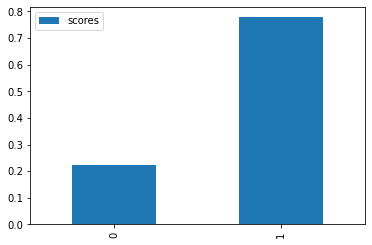

In [87]:
pd.DataFrame.from_dict(explained_prediction.predictions[0]).plot(kind='bar');

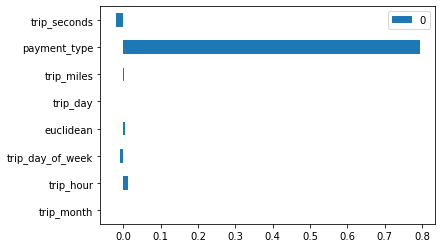

In [143]:
pd.DataFrame.from_dict(explained_prediction.explanations[0].attributions[0].feature_attributions, orient='index').plot(kind='barh');

## Congratulations! Lab wrap-up

## License

<font size=-1>Licensed under the Apache License, Version 2.0 (the \"License\");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at [https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an \"AS IS\" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  See the License for the specific language governing permissions and limitations under the License.</font>